# Autobatching for Bayesian Inference

This notebook demonstrates a simple Bayesian inference example where autobatching makes user code easier to write, easier to read, and less likely to include bugs.

In [1]:
import functools
import itertools
import re
import sys
import time

from matplotlib.pyplot import *

import jax

from jax import lax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random

import numpy as np
import scipy as sp

## Generate a fake binary classification dataset

In [2]:
np.random.seed(10009)

num_features = 10
num_points = 100

true_beta = np.random.randn(num_features).astype(jnp.float32)
all_x = np.random.randn(num_points, num_features).astype(jnp.float32)
y = (np.random.rand(num_points) < sp.special.expit(all_x.dot(true_beta))).astype(jnp.int32)

In [3]:
y

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int32)

## Write the log-joint function for the model

We'll write a non-batched version, a manually batched version, and an autobatched version.

### Non-batched

In [4]:
def log_joint(beta):
    result = 0.
    # Note that no `axis` parameter is provided to `jnp.sum`.
    result = result + jnp.sum(jsp.stats.norm.logpdf(beta, loc=0., scale=1.))
    result = result + jnp.sum(-jnp.log(1 + jnp.exp(-(2*y-1) * jnp.dot(all_x, beta))))
    return result

In [5]:
log_joint(np.random.randn(num_features))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(-213.2356, dtype=float32)

In [6]:
# This doesn't work, because we didn't write `log_prob()` to handle batching.
try:
  batch_size = 10
  batched_test_beta = np.random.randn(batch_size, num_features)

  log_joint(np.random.randn(batch_size, num_features))
except ValueError as e:
  print("Caught expected exception " + str(e))

Caught expected exception Incompatible shapes for broadcasting: shapes=[(100,), (100, 10)]


### Manually batched

In [7]:
def batched_log_joint(beta):
    result = 0.
    # Here (and below) `sum` needs an `axis` parameter. At best, forgetting to set axis
    # or setting it incorrectly yields an error; at worst, it silently changes the
    # semantics of the model.
    result = result + jnp.sum(jsp.stats.norm.logpdf(beta, loc=0., scale=1.),
                           axis=-1)
    # Note the multiple transposes. Getting this right is not rocket science,
    # but it's also not totally mindless. (I didn't get it right on the first
    # try.)
    result = result + jnp.sum(-jnp.log(1 + jnp.exp(-(2*y-1) * jnp.dot(all_x, beta.T).T)),
                           axis=-1)
    return result

In [8]:
batch_size = 10
batched_test_beta = np.random.randn(batch_size, num_features)

batched_log_joint(batched_test_beta)

Array([-147.84033 , -207.02205 , -109.26075 , -243.80833 , -163.0291  ,
       -143.84848 , -160.28773 , -113.771706, -126.60544 , -190.81992 ],      dtype=float32)

### Autobatched with vmap

It just works.

In [9]:
vmap_batched_log_joint = jax.vmap(log_joint)
vmap_batched_log_joint(batched_test_beta)

Array([-147.84033 , -207.02205 , -109.26075 , -243.80833 , -163.0291  ,
       -143.84848 , -160.28773 , -113.771706, -126.60544 , -190.81992 ],      dtype=float32)

## Self-contained variational inference example

A little code is copied from above.

### Set up the (batched) log-joint function

In [10]:
@jax.jit
def log_joint(beta):
    result = 0.
    # Note that no `axis` parameter is provided to `jnp.sum`.
    result = result + jnp.sum(jsp.stats.norm.logpdf(beta, loc=0., scale=10.))
    result = result + jnp.sum(-jnp.log(1 + jnp.exp(-(2*y-1) * jnp.dot(all_x, beta))))
    return result

batched_log_joint = jax.jit(jax.vmap(log_joint))

### Define the ELBO and its gradient

In [11]:
def elbo(beta_loc, beta_log_scale, epsilon):
    beta_sample = beta_loc + jnp.exp(beta_log_scale) * epsilon
    return jnp.mean(batched_log_joint(beta_sample), 0) + jnp.sum(beta_log_scale - 0.5 * np.log(2*np.pi))
 
elbo = jax.jit(elbo)
elbo_val_and_grad = jax.jit(jax.value_and_grad(elbo, argnums=(0, 1)))

### Optimize the ELBO using SGD

In [12]:
def normal_sample(key, shape):
    """Convenience function for quasi-stateful RNG."""
    new_key, sub_key = random.split(key)
    return new_key, random.normal(sub_key, shape)

normal_sample = jax.jit(normal_sample, static_argnums=(1,))

key = random.PRNGKey(10003)

beta_loc = jnp.zeros(num_features, jnp.float32)
beta_log_scale = jnp.zeros(num_features, jnp.float32)

step_size = 0.01
batch_size = 128
epsilon_shape = (batch_size, num_features)
for i in range(1000):
    key, epsilon = normal_sample(key, epsilon_shape)
    elbo_val, (beta_loc_grad, beta_log_scale_grad) = elbo_val_and_grad(
        beta_loc, beta_log_scale, epsilon)
    beta_loc += step_size * beta_loc_grad
    beta_log_scale += step_size * beta_log_scale_grad
    if i % 10 == 0:
        print('{}\t{}'.format(i, elbo_val))

0	-180.8538818359375
10	-113.06045532226562
20	-102.73727416992188
30	-99.787353515625
40	-98.90898132324219
50	-98.29745483398438
60	-98.18632507324219
70	-97.57972717285156
80	-97.28599548339844
90	-97.46996307373047
100	-97.4771728515625
110	-97.5806655883789
120	-97.4943618774414
130	-97.50271606445312
140	-96.86396026611328
150	-97.44198608398438
160	-97.06941223144531
170	-96.84028625488281
180	-97.21336364746094
190	-97.56503295898438
200	-97.26397705078125
210	-97.11979675292969
220	-97.39595031738281
230	-97.16831970214844
240	-97.118408203125
250	-97.24345397949219
260	-97.29788970947266
270	-96.69286346435547
280	-96.96438598632812
290	-97.30055236816406
300	-96.63591766357422
310	-97.03518676757812
320	-97.52909088134766
330	-97.28812408447266
340	-97.07321166992188
350	-97.15619659423828
360	-97.25881958007812
370	-97.19515228271484
380	-97.13092041015625
390	-97.11726379394531
400	-96.938720703125
410	-97.26676940917969
420	-97.35322570800781
430	-97.21006774902344
440	-9

### Display the results

Coverage isn't quite as good as we might like, but it's not bad, and nobody said variational inference was exact.

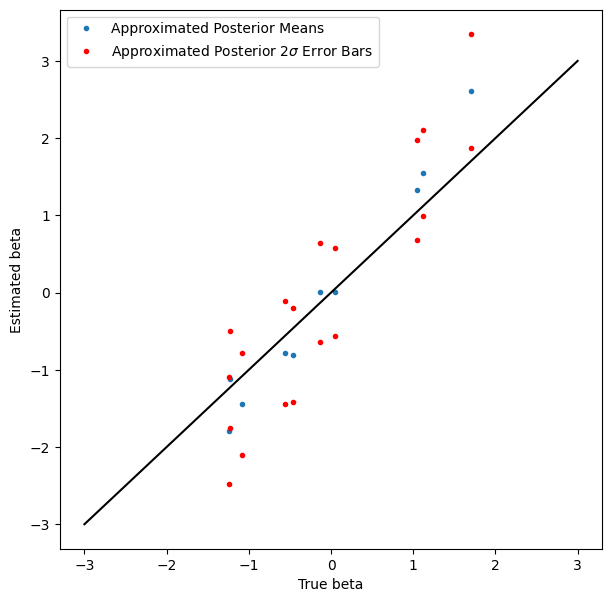

In [13]:
figure(figsize=(7, 7))
plot(true_beta, beta_loc, '.', label='Approximated Posterior Means')
plot(true_beta, beta_loc + 2*jnp.exp(beta_log_scale), 'r.', label='Approximated Posterior $2\sigma$ Error Bars')
plot(true_beta, beta_loc - 2*jnp.exp(beta_log_scale), 'r.')
plot_scale = 3
plot([-plot_scale, plot_scale], [-plot_scale, plot_scale], 'k')
xlabel('True beta')
ylabel('Estimated beta')
legend(loc='best')